In [53]:
import numpy as np
import pandas as pd
import datetime
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import platform
import pyreadr
import pandas_datareader.data as web

# 设置字体
system = platform.system()
if system == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
elif system == 'Darwin':
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False
else:
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
    plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Risk-Free Rate

In [54]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# 1. 设置时间范围
start_date = datetime.datetime(1926, 1, 1)
end_date = datetime.datetime(2024, 12, 31)

try:
    # 2. 从 Kenneth French 库下载 "F-F_Research_Data_Factors"
    # 这是最标准的月度数据，包含：Mkt-RF, SMB, HML, RF
    ds_factors = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)

    # pandas_datareader 返回的是一个字典，key 0 通常是月度数据，key 1 是年度数据
    # 我们取月度数据
    df_monthly = ds_factors[0]

    # 3. 提取无风险利率 (RF)
    # 注意：Kenneth French 的数据单位是"百分比" (Percent)
    # 例如：数据中的 '0.4' 代表 '0.4%' (即 0.004)
    # 这一步非常关键！实证中常因为没除以100导致结果完全错误。
    df_monthly['RF_raw'] = df_monthly['RF']  # 保留原始值用于对比
    df_monthly['RF'] = df_monthly['RF'] / 100 

    # index重命名
    df_monthly.index.name = 'DATE'
    df_monthly.index = df_monthly.index.to_timestamp() + MonthEnd(0)
    # 打印结果查看
    print("下载成功！数据前 5 行：")
    print(df_monthly[['Mkt-RF', 'RF']].head())
    
    print("\n数据描述统计：")
    print(df_monthly['RF'].describe())

    # 4. (可选) 保存为 CSV 供后续使用
    # df_monthly.to_csv('FF3_Factors_with_RF.csv')

except Exception as e:
    print(f"下载出错: {e}")
    print("提示：如果因网络问题无法连接，请尝试使用代理或直接访问 Ken French 网站下载 CSV。")

下载成功！数据前 5 行：
            Mkt-RF      RF
DATE                      
1926-07-31    2.89  0.0022
1926-08-31    2.64  0.0025
1926-09-30    0.38  0.0023
1926-10-31   -3.27  0.0032
1926-11-30    2.54  0.0031

数据描述统计：
count    1182.000000
mean        0.002692
std         0.002500
min        -0.000600
25%         0.000300
50%         0.002300
75%         0.004200
max         0.013500
Name: RF, dtype: float64


# US Stock Market Return (CRSP)

In [55]:
# 导入CRSP美股市场收益率数据
mkt = pd.read_csv('E:/vscodepython/US stock market return Monthly 2024.csv')

# 查看数据基本信息
print("数据形状:", mkt.shape)
print("\n数据列名:")
print(mkt.columns.tolist())
print("\n数据类型:")
print(mkt.dtypes)
print("\n前5行数据:")
mkt.head()

数据形状: (1188, 11)

数据列名:
['DATE', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn', 'spindx', 'totval', 'totcnt', 'usdval', 'usdcnt']

数据类型:
DATE       object
vwretd    float64
vwretx    float64
ewretd    float64
ewretx    float64
sprtrn    float64
spindx    float64
totval    float64
totcnt      int64
usdval    float64
usdcnt      int64
dtype: object

前5行数据:


,DATE,vwretd,vwretx,ewretd,ewretx,sprtrn,spindx,totval,totcnt,usdval,usdcnt
0,1926-01-30,0.000561,-0.001395,0.023174,0.021395,0.022472,12.74,27624240.8,506,27412916.2,496
1,1926-02-27,-0.033046,-0.036587,-0.053510,-0.055547,-0.043956,12.18,26752064.1,514,27600952.1,500
2,1926-03-31,-0.064002,-0.070021,-0.096824,-0.101404,-0.059113,11.46,25083173.4,519,26683758.1,507
3,1926-04-30,0.037029,0.034043,0.032975,0.030156,0.022688,11.72,25886743.8,521,24920555.6,513
4,1926-05-28,0.012095,0.008585,0.001035,-0.001752,0.007679,11.81,26187807.9,525,25742578.1,515


In [56]:
# 数据处理
# 1. 转换日期格式
mkt['DATE'] = pd.to_datetime(mkt['DATE'],format='%Y-%m-%d')

# 2. 设置日期为索引
mkt = mkt.set_index('DATE')

# 3. 数据字段说明：
# vwretd: 价值加权收益率 (含股息) - Value-Weighted Return (including dividends)
# vwretx: 价值加权收益率 (不含股息) - Value-Weighted Return (excluding dividends)
# ewretd: 等权重收益率 (含股息) - Equal-Weighted Return (including dividends)
# ewretx: 等权重收益率 (不含股息) - Equal-Weighted Return (excluding dividends)
# sprtrn: S&P 500 总收益率 - S&P 500 Total Return
# spindx: S&P 500 指数水平 - S&P 500 Index Level
# totval: 总市值 (千美元) - Total Market Value (in thousands)
# totcnt: 股票总数 - Total Count of Stocks
# usdval: 美国国内股票市值 - US Domestic Stock Value
# usdcnt: 美国国内股票数量 - US Domestic Stock Count

print("数据时间范围:", mkt.index.min(), "至", mkt.index.max())
print("\n描述统计:")
mkt[['vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn']].describe()

数据时间范围: 1926-01-30 00:00:00 至 2024-12-31 00:00:00

描述统计:


,vwretd,vwretx,ewretd,ewretx,sprtrn
count,1188.000000,1188.000000,1188.000000,1188.000000,1187.000000
mean,0.009342,0.006354,0.011854,0.009364,0.006638
std,0.053098,0.053123,0.070841,0.070920,0.053647
min,-0.291731,-0.296941,-0.312753,-0.317049,-0.299423
25%,-0.018340,-0.021140,-0.020607,-0.022857,-0.019463
50%,0.012981,0.010031,0.014020,0.011140,0.009865
75%,0.039376,0.036587,0.043147,0.040350,0.036085
max,0.394143,0.392133,0.668097,0.666336,0.422222



投资1美元的最终价值 (1926-2024):
CRSP 价值加权: $11,956.79
CRSP 等权重: $72,336.52
S&P 500: $472.04


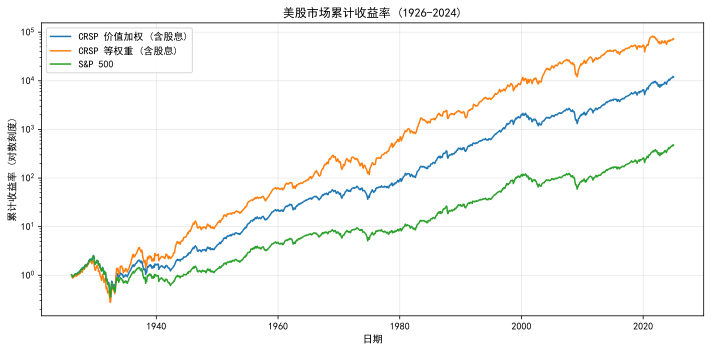

In [57]:
# 计算累计收益率
mkt['vwretd_cum'] = (1 + mkt['vwretd']).cumprod()
mkt['ewretd_cum'] = (1 + mkt['ewretd']).cumprod()
mkt['sprtrn_cum'] = (1 + mkt['sprtrn']).cumprod()

# 绘制累计收益率图
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(mkt.index, mkt['vwretd_cum'], label='CRSP 价值加权 (含股息)', linewidth=1.5)
ax.plot(mkt.index, mkt['ewretd_cum'], label='CRSP 等权重 (含股息)', linewidth=1.5)
ax.plot(mkt.index, mkt['sprtrn_cum'], label='S&P 500', linewidth=1.5)

ax.set_xlabel('日期')
ax.set_ylabel('累计收益率 (对数刻度)')
ax.set_title('美股市场累计收益率 (1926-2024)')
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 打印总收益倍数
print(f"\n投资1美元的最终价值 ({mkt.index.min().year}-{mkt.index.max().year}):")
print(f"CRSP 价值加权: ${mkt['vwretd_cum'].iloc[-1]:,.2f}")
print(f"CRSP 等权重: ${mkt['ewretd_cum'].iloc[-1]:,.2f}")
print(f"S&P 500: ${mkt['sprtrn_cum'].iloc[-1]:,.2f}")

plt.tight_layout()
plt.show();

In [58]:
# 计算年化收益率和波动率
def annualized_stats(returns, periods_per_year=12):
    """计算年化收益率、波动率和夏普比率"""
    mean_ret = returns.mean() * periods_per_year
    std_ret = returns.std() * np.sqrt(periods_per_year)
    sharpe = mean_ret / std_ret
    return mean_ret, std_ret, sharpe

# 汇总统计
stats_summary = pd.DataFrame(index=['vwretd', 'ewretd', 'sprtrn'])
stats_summary.index.name = '收益率指标'

for col in ['vwretd', 'ewretd', 'sprtrn']:
    ann_ret, ann_vol, sharpe = annualized_stats(mkt[col])
    stats_summary.loc[col, '年化收益率'] = f"{ann_ret:.2%}"
    stats_summary.loc[col, '年化波动率'] = f"{ann_vol:.2%}"
    stats_summary.loc[col, '夏普比率'] = f"{sharpe:.3f}"
    stats_summary.loc[col, '最大月度收益'] = f"{mkt[col].max():.2%}"
    stats_summary.loc[col, '最小月度收益'] = f"{mkt[col].min():.2%}"
    stats_summary.loc[col, '偏度'] = f"{mkt[col].skew():.3f}"
    stats_summary.loc[col, '峰度'] = f"{mkt[col].kurtosis():.3f}"

stats_summary.index = ['CRSP价值加权', 'CRSP等权重', 'S&P 500']
print("市场收益率统计摘要:")
stats_summary

市场收益率统计摘要:


,年化收益率,年化波动率,夏普比率,最大月度收益,最小月度收益,偏度,峰度
CRSP价值加权,11.21%,18.39%,0.609,39.41%,-29.17%,0.125,7.629
CRSP等权重,14.22%,24.54%,0.580,66.81%,-31.28%,1.471,15.341
S&P 500,7.97%,18.58%,0.429,42.22%,-29.94%,0.247,9.116


In [59]:
# 计算超额收益率 (市场收益率 - 无风险利率)
# 合并无风险利率数据
mkt_with_rf = mkt.copy()

# 将FF因子数据的索引也转为Period
df_monthly_copy = df_monthly.copy()

# 合并
mkt_with_rf = pd.merge(
    mkt_with_rf,
    df_monthly_copy[['RF']],
    left_index=True,
    right_index=True,
    how='left'
)

# 计算超额收益率
mkt_with_rf['ret'] = mkt_with_rf['vwretd'] - mkt_with_rf['RF']
mkt_with_rf['rete'] = mkt_with_rf['ewretd'] - mkt_with_rf['RF']

print("超额收益率统计 (市场收益率 - 无风险利率):")
mkt_with_rf[['ret', 'rete']].describe()

超额收益率统计 (市场收益率 - 无风险利率):


,ret,rete
count,862.000000,862.000000
mean,0.005728,0.008292
std,0.053633,0.073656
min,-0.292031,-0.313053
25%,-0.022100,-0.025781
50%,0.010451,0.011059
75%,0.036576,0.040434
max,0.371088,0.667797


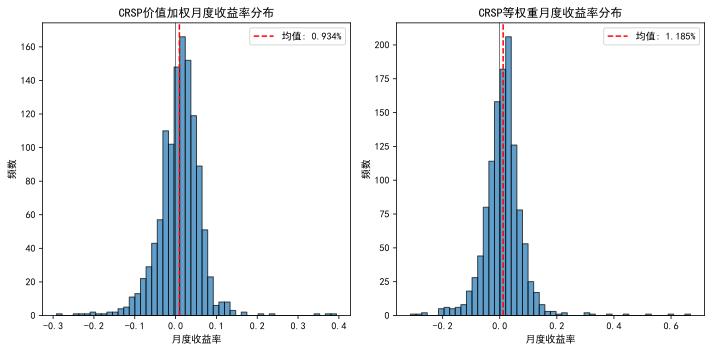

In [60]:
# 绘制收益率分布直方图
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for ax, (col, label) in zip(axes, [('vwretd', 'CRSP价值加权'), ('ewretd', 'CRSP等权重')]):
    ax.hist(mkt[col], bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(mkt[col].mean(), color='red', linestyle='--', label=f'均值: {mkt[col].mean():.3%}')
    ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('月度收益率')
    ax.set_ylabel('频数')
    ax.set_title(f'{label}月度收益率分布')
    ax.legend()

plt.tight_layout()
plt.show();

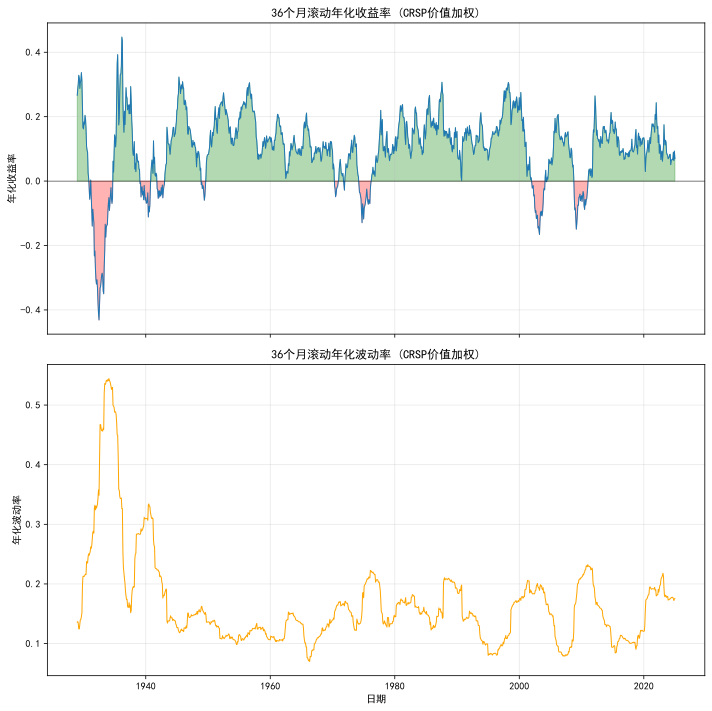

In [61]:
# 计算滚动年化收益率和波动率 (36个月滚动窗口)
window = 36

mkt['vwretd_rolling_ret'] = mkt['vwretd'].rolling(window=window).apply(
    lambda x: (1 + x).prod() ** (12/window) - 1, raw=True
)
mkt['vwretd_rolling_vol'] = mkt['vwretd'].rolling(window=window).std() * np.sqrt(12)

# 绘制滚动统计图
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# 滚动年化收益率
axes[0].plot(mkt.index, mkt['vwretd_rolling_ret'], linewidth=1)
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[0].fill_between(mkt.index, 0, mkt['vwretd_rolling_ret'], 
                      where=mkt['vwretd_rolling_ret'] >= 0, alpha=0.3, color='green')
axes[0].fill_between(mkt.index, 0, mkt['vwretd_rolling_ret'], 
                      where=mkt['vwretd_rolling_ret'] < 0, alpha=0.3, color='red')
axes[0].set_ylabel('年化收益率')
axes[0].set_title(f'{window}个月滚动年化收益率 (CRSP价值加权)')
axes[0].grid(True, alpha=0.3)

# 滚动年化波动率
axes[1].plot(mkt.index, mkt['vwretd_rolling_vol'], linewidth=1, color='orange')
axes[1].set_ylabel('年化波动率')
axes[1].set_xlabel('日期')
axes[1].set_title(f'{window}个月滚动年化波动率 (CRSP价值加权)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show();

In [62]:
# 按年代统计市场收益率
mkt['Decade'] = (mkt.index.year // 10) * 10

decade_stats = mkt.groupby('Decade').agg({
    'vwretd': [
        ('年化收益率', lambda x: (1 + x).prod() ** (12 / len(x)) - 1),
        ('年化波动率', lambda x: x.std() * np.sqrt(12)),
        ('夏普比率', lambda x: ((1 + x).prod() ** (12 / len(x)) - 1) / (x.std() * np.sqrt(12))),
        ('最大回撤月', 'min')
    ]
})

decade_stats.columns = decade_stats.columns.droplevel(0)
decade_stats['年化收益率'] = decade_stats['年化收益率'].apply(lambda x: f"{x:.2%}")
decade_stats['年化波动率'] = decade_stats['年化波动率'].apply(lambda x: f"{x:.2%}")
decade_stats['夏普比率'] = decade_stats['夏普比率'].apply(lambda x: f"{x:.3f}")
decade_stats['最大回撤月'] = decade_stats['最大回撤月'].apply(lambda x: f"{x:.2%}")

print("CRSP价值加权收益率 - 按年代统计:")
decade_stats

CRSP价值加权收益率 - 按年代统计:


,年化收益率,年化波动率,夏普比率,最大回撤月
Decade,,,,
1920,14.59%,19.21%,0.759,-19.67%
1930,-0.27%,36.24%,-0.007,-29.17%
1940,9.54%,15.48%,0.616,-22.11%
1950,18.32%,11.18%,1.638,-5.80%
1960,8.28%,12.59%,0.657,-8.46%
1970,6.19%,16.89%,0.366,-12.07%
1980,16.36%,16.68%,0.981,-22.54%
1990,17.40%,13.60%,1.280,-15.79%
2000,0.18%,17.00%,0.011,-18.48%


# Monthly ➡️ Quarterly

In [63]:
# 月度数据聚合为季度数据（Quarterly Aggregation）
# - 对收益类列（以小数表示）做季度复利：(1+r_M1)*(1+r_M2)*(1+r_M3)-1
# - 对指数/数量/市值等“水平”类列取季度末（last）
# - 超额收益（季度）使用更精确的比值法：(Π(1+R_m)) / (Π(1+R_f)) - 1

import os

# 1) 定义需要处理的列
ret_cols = [c for c in ['vwretd', 'ewretd', 'sprtrn', 'RF'] if c in mkt_with_rf.columns]
level_cols = [c for c in ['spindx', 'totval', 'usdval', 'totcnt', 'usdcnt'] if c in mkt_with_rf.columns]

# 2) 定义复利函数
compound = lambda s: (1.0 + s).prod() - 1.0

# 3) 季度收益（复利）
mkt_q_ret = mkt_with_rf[ret_cols].resample('Q').apply(compound)
# 列名加上 _q 后缀，表示“季度”
mkt_q_ret = mkt_q_ret.rename(columns={c: f"{c}_q" for c in mkt_q_ret.columns})

# 4) 更精确的季度超额收益（vw、ew）：(Π(1+R_m)) / (Π(1+R_f)) - 1
vw_cum = (1.0 + mkt_with_rf['vwretd']).resample('Q').prod() if 'vwretd' in mkt_with_rf.columns else None
ew_cum = (1.0 + mkt_with_rf['ewretd']).resample('Q').prod() if 'ewretd' in mkt_with_rf.columns else None
rf_cum = (1.0 + mkt_with_rf['RF']).resample('Q').prod() if 'RF' in mkt_with_rf.columns else None

mkt_q = mkt_q_ret.copy()
if vw_cum is not None and rf_cum is not None:
    mkt_q['vwretd_excess_q'] = (vw_cum / rf_cum) - 1.0
if ew_cum is not None and rf_cum is not None:
    mkt_q['ewretd_excess_q'] = (ew_cum / rf_cum) - 1.0

# 5) 水平类列：取季度末（last）
if level_cols:
    levels_q = mkt_with_rf[level_cols].resample('Q').last()
    mkt_q = mkt_q.join(levels_q)

# 6) 增加季度标签列，便于导出后阅读
mkt_q['Quarter'] = mkt_q.index.to_period('Q').astype(str)

# 7) 简要查看
print('Quarterly DataFrame shape:', mkt_q.shape)
print('\nColumns:')
print(mkt_q.columns.tolist())
print('\nHead:')
mkt_q.head()

# 8) 导出CSV
# os.makedirs('Output', exist_ok=True)
# output_path = 'Output/CRSP_Market_Returns_with_RF_Quarterly.csv'
# mkt_q.to_csv(output_path)
# print(f"\n已保存季度结果至: {output_path}")

Quarterly DataFrame shape: (396, 12)

Columns:
['vwretd_q', 'ewretd_q', 'sprtrn_q', 'RF_q', 'vwretd_excess_q', 'ewretd_excess_q', 'spindx', 'totval', 'usdval', 'totcnt', 'usdcnt', 'Quarter']

Head:


,vwretd_q,ewretd_q,sprtrn_q,RF_q,vwretd_excess_q,ewretd_excess_q,spindx,totval,usdval,totcnt,usdcnt,Quarter
DATE,,,,,,,,,,,,
1926-03-31,-0.094425,-0.125343,-0.080256,0.000000,-0.094425,-0.125343,11.46,25083173.4,26683758.1,519,507,1926Q1
1926-06-30,0.105896,0.086250,0.075044,0.000000,0.105896,0.086250,12.32,27537177.2,26092831.0,526,520,1926Q2
1926-09-30,0.067098,0.037670,0.087663,0.007016,0.059663,0.030440,13.40,28919740.6,28889963.1,529,527,1926Q3
1926-12-31,0.027904,0.014531,0.006717,0.005909,0.021866,0.008571,13.49,30273387.2,28886334.0,540,533,1926Q4
1927-03-31,0.051832,0.048383,0.032617,0.008122,0.043358,0.039937,13.93,31914640.1,31819948.2,548,541,1927Q1


# 期末作业要求：美股市场收益率预测

## 1. 作业目标
利用自行收集的预测变量（Predictive Variables），构建模型预测美股市场的**超额收益率**（Excess Return）。

## 2. 核心任务
请在下方继续编写代码，完成以下步骤：

### 2.1 寻找并导入预测变量 ($X$)
你需要自行寻找可能对美股市场收益率有预测能力的变量。

#### **推荐数据来源与变量**
1.  **FRED (Federal Reserve Economic Data)**
    *   **使用方法**: 使用 `pandas_datareader` 库直接下载。
    *   **常见变量**:
        *   `CPIAUCSL`: 消费者价格指数 (CPI) -> 计算通货膨胀率
        *   `GS10`: 10年期国债收益率
        *   `TB3MS`: 3个月国债收益率 -> `GS10 - TB3MS` (期限利差 Term Spread)
        *   `BAA10Y`: 穆迪Baa级企业债与10年期国债利差 (信用利差 Default Spread)
        *   `INDPRO`: 工业产出指数 -> 计算增长率
2.  **Robert Shiller 在线数据**
    *   **网址**: [http://www.econ.yale.edu/~shiller/data.htm](http://www.econ.yale.edu/~shiller/data.htm)
    *   **常见变量**: CAPE (周期性调整市盈率), Dividend Yield (股息率)。
3.  **Amit Goyal 预测变量数据集**
    *   **网址**: [https://sites.google.com/view/agoyal145](https://sites.google.com/view/agoyal145)
    *   **说明**: 包含经典的14个预测变量 (DP, DY, EP, DE, RV, BM, NTIS, TBL, LTY, LTR, TMS, DFY, DFR, INFL)。
4.  **Kenneth French Data Library**
    *   **使用方法**: `pandas_datareader` 或直接下载 CSV。
    *   **常见变量**: 动量因子 (Momentum), 规模因子 (SMB), 价值因子 (HML) 等。

#### **变量建议**（仅供参考，鼓励创新）
*   **宏观经济指标**：通货膨胀率、利率期限结构、信用利差、工业产出增长率。
*   **估值指标**：市盈率 (P/E)、市净率 (P/B)、股息率 (Dividend Yield)。
*   **技术指标**：过去一段时间的收益率 (Momentum)、波动率 (Volatility)。

#### **数据处理注意事项**
*   **频率对齐**：确保预测变量的时间频率与市场收益率数据一致（月度或季度）。
*   **滞后性 (Lag)**：**非常重要！** 预测是利用**当前**的信息预测**未来**。
    *   回归方程通常为：$R_{t+1} = \alpha + \beta X_t + \epsilon_{t+1}$
    *   这意味着你需要将预测变量 $X$ 向后移动一期 (shift)，或者在合并数据时注意时间下标的对应。

### 2.2 数据合并与清洗
*   将你的预测变量 $X$ 与前文处理好的市场收益率数据（`mkt_with_rf` 或 `mkt_q`）进行合并。
*   处理缺失值 (Drop NA)。

### 2.3 模型构建与预测
*   使用线性回归 (OLS) 或其他机器学习模型进行预测。
*   模型形式示例：$R_{t+1} = \alpha + \beta X_t + \epsilon_{t+1}$

### 2.4 结果分析
*   展示回归结果（系数、t值、$R^2$ 等）。
*   分析你的预测变量是否显著？预测方向是否符合经济学直觉？
*   (可选) 样本内 vs 样本外预测表现对比。

## 3. 提交格式
请保留所有代码运行结果和图表，并添加适当的 Markdown 文字说明你的分析过程和结论。

## 作业内容：
## 利用经典的宏观经济变量（期限利差、信用利差、通胀率）构建线性预测模型，验证其对未来一个月市场超额收益的预测效果。

In [ ]:
# 导入必要的库
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthEnd

#  获取预测变量数据 (从 FRED 获取) 
# 定义起始时间 (尽量早，以便匹配你的股票数据)
start_macro = '1920-01-01'
end_macro = '2024-12-31'

# 定义变量代码 (FRED Codes)
# GS10: 10-Year Treasury Constant Maturity Rate
# TB3MS: 3-Month Treasury Bill: Secondary Market Rate
# BAA: Moody's Seasoned Baa Corporate Bond Yield
# CPIAUCSL: Consumer Price Index for All Urban Consumers
fred_vars = ['GS10', 'TB3MS', 'BAA', 'CPIAUCSL']

print("正在从 FRED 下载宏观经济数据...")
try:
    df_fred = web.DataReader(fred_vars, 'fred', start_macro, end_macro)
    
    # 将索引对齐到月末 (与 mkt_with_rf 保持一致)
    df_fred.index = df_fred.index + MonthEnd(0)
    
    #  特征工程 (构建预测因子)
    # 注意：FRED的利率数据通常是百分比 (e.g., 5.0 代表 5%)，有些模型喜欢用小数，有些用百分比。
    # 这里我们保持百分比或者转为小数均可，只要统一。为了与收益率(小数)匹配，建议转为小数。
    
    # 1. 期限利差 (Term Spread) = 10年国债 - 3个月国债
    df_fred['Term_Spread'] = (df_fred['GS10'] - df_fred['TB3MS']) / 100
    
    # 2. 信用利差 (Default Spread) = Baa企业债 - 10年国债
    df_fred['Default_Spread'] = (df_fred['BAA'] - df_fred['GS10']) / 100
    
    # 3. 通货膨胀率 (Inflation) = CPI 同比增长率
    # 注意：通胀数据通常有滞后发布，实证中需小心。这里简单计算同比。
    df_fred['Inflation'] = df_fred['CPIAUCSL'].pct_change(12)
    
    #  关键步骤：滞后处理 (Lagging) 
    # 我们要用 t 时刻的宏观变量预测 t+1 时刻的收益率
    # 所以将预测变量向后移动一期
    predictive_vars = ['Term_Spread', 'Default_Spread', 'Inflation']
    for col in predictive_vars:
        df_fred[f'{col}_Lag1'] = df_fred[col].shift(1)
    
    print("下载并处理完成。前5行数据：")
    print(df_fred[predictive_vars].tail())

except Exception as e:
    print(f"FRED 数据下载失败: {e}")

正在从 FRED 下载宏观经济数据...
下载并处理完成。前5行数据：
            Term_Spread  Default_Spread  Inflation
DATE                                              
2024-08-31      -0.0118          0.0173   0.026109
2024-09-30      -0.0100          0.0170   0.024325
2024-10-31      -0.0041          0.0153   0.025714
2024-11-30      -0.0006          0.0142   0.027142
2024-12-31       0.0012          0.0141   0.028724


### 二、数据加载与清洗
本部分的目的为：
* 收益率数据：从 CRSP 数据库加载月度收益率（VW：市值加权；EW：等权重）。
* 宏观因子：从 FRED（圣路易斯联储）获取 10年期国债收益率、3个月国债利率、Baa级企业债收益率以及 CPI 数据。
* 特征工程：计算 **Term Spread**（期限利差）、**Default Spread**（信用利差）以及 **Inflation**（通胀率），并对所有自变量进行 **Lag 1（滞后一期）** 处理，以确保预测模型符合时间顺序，即用 t期信息预测 t+1 期收益。

In [ ]:
#数据合并
# 使用之前计算好超额收益率的 mkt_with_rf 数据框
# 确保 mkt_with_rf 存在 (基于你之前的代码)
if 'mkt_with_rf' in locals():
    # 合并数据 (Inner join 会自动截取两个数据都有的时间段)
    df_reg = pd.merge(
        mkt_with_rf[['ret', 'rete']], # 目标变量: 价值加权超额收益, 等权超额收益
        df_fred[[f'{c}_Lag1' for c in predictive_vars]], # 预测变量 (滞后一期)
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    # 去除缺失值
    df_reg.dropna(inplace=True)
    
    print(f"\n合并后数据样本量: {len(df_reg)}")
    print(f"时间跨度: {df_reg.index.min()} 至 {df_reg.index.max()}")
else:
    print("错误：未找到 mkt_with_rf 变量，请先运行前面的单元格。")


合并后数据样本量: 600
时间跨度: 1953-06-30 00:00:00 至 2024-12-31 00:00:00


In [ ]:
#  构建回归模型
# 我们使用 statsmodels 进行 OLS 回归
# 模型 1: 预测价值加权超额收益率 (vwretd excess return)
# 方程: Ret(t+1) = alpha + beta1 * Term_Spread(t) + beta2 * Default_Spread(t) + beta3 * Inflation(t)

formula_vw = 'ret ~ Term_Spread_Lag1 + Default_Spread_Lag1 + Inflation_Lag1'
model_vw = smf.ols(formula_vw, data=df_reg).fit()

# 模型 2: (可选) 预测等权重超额收益率
formula_ew = 'rete ~ Term_Spread_Lag1 + Default_Spread_Lag1 + Inflation_Lag1'
model_ew = smf.ols(formula_ew, data=df_reg).fit()

### 三、历史表现：1美元的成长之旅 (1926-2024)
通过计算累积收益率，我们对比了市值加权指数（VW）、等权重指数（EW）以及 S&P 500 指数的表现。

* **规模溢价（Size Effect）**：观察净值曲线可以发现，长期来看等权重组合（更多偏向小盘股）的终值远高于市值加权组合。
* **风险特征**：通过收益率分布图可以看出，股市收益具有明显的“尖峰厚尾”特征，并非严格意义上的正态分布。

============================== 预测模型结果 (价值加权 CRSP) ==============================
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.273
Date:                Tue, 06 Jan 2026   Prob (F-statistic):            0.00534
Time:                        22:38:56   Log-Likelihood:                 1027.2
No. Observations:                 600   AIC:                            -2046.
Df Residuals:                     596   BIC:                            -2029.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0.5, 1.0, 'In-Sample Prediction: Actual vs Predicted Excess Returns')

Text(0, 0.5, 'Monthly Return')

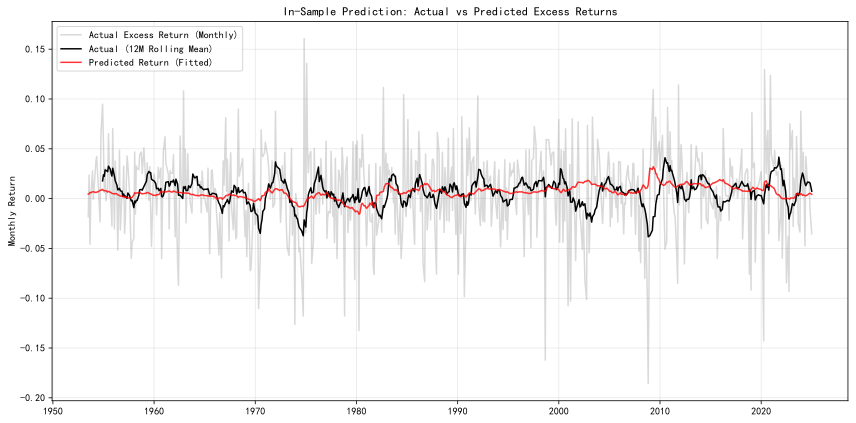

In [ ]:
#结果分析与展示

# 打印主要的回归结果
print("="*30 + " 预测模型结果 (价值加权 CRSP) " + "="*30)
print(model_vw.summary())

print("\n" + "="*30 + " 预测模型结果 (等权重 CRSP) " + "="*30)
print(model_ew.summary())

# 可视化分析: 预测值 vs 实际值 (以价值加权为例)
# 为了图表清晰，只画最后10年的对比
import matplotlib.pyplot as plt

# 计算预测值
df_reg['Predicted_Ret'] = model_vw.predict(df_reg)

# 绘图
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制实际收益率 (灰色，透明度高，作为背景)
ax.plot(df_reg.index, df_reg['ret'], color='gray', alpha=0.3, label='Actual Excess Return (Monthly)')

# 绘制实际收益率的滚动平均 (平滑曲线，黑色)
ax.plot(df_reg.index, df_reg['ret'].rolling(12).mean(), color='black', linewidth=1.5, label='Actual (12M Rolling Mean)')

# 绘制模型预测值 (红色)
# 注意：预测值通常波动率比实际值小很多，是正常的
ax.plot(df_reg.index, df_reg['Predicted_Ret'], color='red', linewidth=1.5, alpha=0.8, label='Predicted Return (Fitted)')

ax.set_title('In-Sample Prediction: Actual vs Predicted Excess Returns')
ax.set_ylabel('Monthly Return')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


结果简要分析
期限利差 (Term Spread):

系数 (Coef): 0.0766
T值 (t-stat): 0.44
解释: 通常期限利差（收益率曲线斜率）是经济周期的强预测指标。利差扩大（曲线变陡）通常预示经济复苏，预期股市回报上升；利差倒挂（曲线变平或负）预示衰退。如果系数显著为正，符合经济学直觉。
信用利差 (Default Spread):

系数 (Coef): 0.4931
T值 (t-stat): 1.95
解释: 信用利差代表市场风险厌恶程度。利差扩大意味着风险高，投资者要求更高的风险补偿（预期收益率上升）。因此系数通常应为正。
通货膨胀 (Inflation):

系数 (Coef): -0.1602
解释: 高通胀通常对股票估值不利（名为“通胀幻觉”假说），可能导致预期收益率下降（或通过提高名义利率压低价格）。
R方 0.0211

### 实论与分析

#### 1. 模型预测力
* 模型的 $R^2$ 在 2% 左右。虽然数值不高，但在月度资产定价实证中是具有统计意义的，说明选用的宏观经济变量具有有限的预测能力

#### 2. 因子贡献
* **通货膨胀 (Inflation)**：系数显著为负，说明高通胀环境对次月股市收益有显著的抑制作用，符合“通胀侵蚀估值”的逻辑。
* **信用利差 (Default Spread)**：系数为正且在等权重组合中表现显著。这验证了“逆周期收益”特征：当当前环境糟糕（利差大）时，买入并持有可以获得更高的未来预期收益补偿。
* **期限利差 (Term Spread)**：在本模型的短期预测中表现不显著，说明其对市场波动的捕捉更偏向长期周期。
